# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import (
    train_test_split
)
from sklearn.linear_model import (
    LinearRegression
)
from sklearn.linear_model import (
    LinearRegression    
)
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)
from sklearn.metrics import (
    mean_squared_error
)
from scipy import stats as st

In [2]:
BUDGET = 1e10
DEVELOPMENT_POINTS = 200
PRICE = 4.5*10**5
# основные данные бюджет, кол-во разрабатываемых точек в регионе, цена за 1 ед продукта

In [3]:
data_0 = pd.read_csv('/datasets/geo_data_0.csv')
data_1 = pd.read_csv('/datasets/geo_data_1.csv')
data_2 = pd.read_csv('/datasets/geo_data_2.csv')
# загружаем датасеты 3-х регионов

In [4]:
print(data_0.head())
print(data_0.info())
print(data_0.duplicated().sum())
print(data_0.describe())
# оцениваем данные датасета региона № 0

      id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
0
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.502647      92.500000
std         0.871832       0.504433       3.248248     

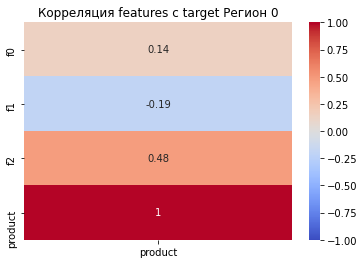

In [5]:
sns.heatmap(data_0.corr()[['product']], vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm')
plt.title('Корреляция features c target Регион 0')
plt.show()

In [6]:
print(data_1.head())
print(data_1.info())
print(data_1.duplicated().sum())
print(data_1.describe())
# оцениваем данные датасета региона № 1

      id         f0         f1        f2     product
0  kBEdx -15.001348  -8.276000 -0.005876    3.179103
1  62mP7  14.272088  -3.475083  0.999183   26.953261
2  vyE1P   6.263187  -5.948386  5.001160  134.766305
3  KcrkZ -13.081196 -11.506057  4.999415  137.945408
4  AHL4O  12.702195  -8.147433  5.004363  134.766305
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
0
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        1.141296      -4.796579       2.494541      68.825000
std         8.965932       5.119872       1

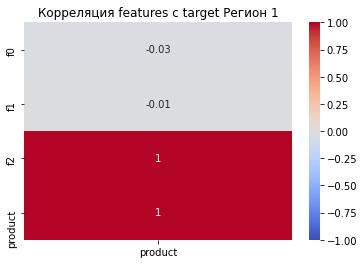

In [7]:
sns.heatmap(data_1.corr()[['product']], vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm')
plt.title('Корреляция features c target Регион 1')
plt.show()

In [8]:
print(data_2.head())
print(data_2.info())
print(data_2.duplicated().sum())
print(data_2.describe())
# оцениваем данные датасета региона № 2

      id        f0        f1        f2     product
0  fwXo0 -1.146987  0.963328 -0.828965   27.758673
1  WJtFt  0.262778  0.269839 -2.530187   56.069697
2  ovLUW  0.194587  0.289035 -5.586433   62.871910
3  q6cA6  2.236060 -0.553760  0.930038  114.572842
4  WPMUX -0.515993  1.716266  5.899011  149.600746
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
0
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.002023      -0.002081       2.495128      95.000000
std         1.732045       1.730417       3.473445     

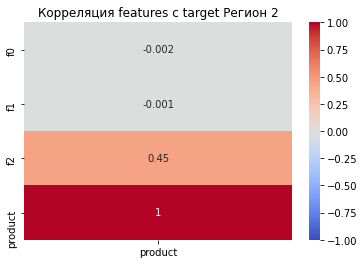

In [9]:
sns.heatmap(data_2.corr()[['product']], vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm')
plt.title('Корреляция features c target Регион 2')
plt.show()

In [10]:
data_0_ohe = data_0.drop('id', axis=1)
data_1_ohe = data_1.drop('id', axis=1)
data_2_ohe = data_2.drop('id', axis=1)
    
for i in [data_0_ohe, data_1_ohe, data_2_ohe]:
    print(i.columns)    
# удаляем столбец id в датасетах т.к. он лишний для обучения

Index(['f0', 'f1', 'f2', 'product'], dtype='object')
Index(['f0', 'f1', 'f2', 'product'], dtype='object')
Index(['f0', 'f1', 'f2', 'product'], dtype='object')


In [11]:
features_0 = data_0_ohe.drop('product', axis=1)
features_1 = data_1_ohe.drop('product', axis=1)
features_2 = data_2_ohe.drop('product', axis=1)

target_0 = data_0_ohe['product']
target_1 = data_1_ohe['product']
target_2 = data_2_ohe['product']

# подготавливаем фичи для дальнейшего маштабирования
# и таргеты

<div class="alert alert-block alert-info"><b>
**Выводы**

- Загрузили данные по регионам 0, 1 и 2 в датасеты data_0, data_1 и data_2
- Ознакомились с оновной информацией датасетов на предмет пропусков, формата данных
- Обнаружили в датасете по региону 1 сильную положительную корреляцию признака f2 с целевым признаком product
- Уалили из датасетов столбец id т.к. он не нужен для модели
- Выделили в отдельные переменные признаки и целевые признаки по всем регионам
</b>

## Обучение и проверка модели

In [12]:
features_0_train, features_0_valid, target_0_train, target_0_valid = train_test_split(
    features_0, target_0, test_size=0.25, random_state=12345
)

features_1_train, features_1_valid, target_1_train, target_1_valid = train_test_split(
    features_1, target_1, test_size=0.25, random_state=12345
)

features_2_train, features_2_valid, target_2_train, target_2_valid = train_test_split(
    features_2, target_2, test_size=0.25, random_state=12345
)
# фичи и таргеты  разбиваем на выборки train/valid в пропорции 75/25



In [13]:
pd.options.mode.chained_assignment = None

numeric = ['f0', 'f1', 'f2']
scaler = StandardScaler()

def scal(features):
    features[numeric] = scaler.fit_transform(features[numeric])
    return features[numeric]

features_0_train[numeric] = scal(features_0_train)
features_0_valid[numeric] = scaler.transform(features_0_valid[numeric])

features_1_train[numeric] = scal(features_1_train)
features_1_valid[numeric] = scaler.transform(features_1_valid[numeric])

features_2_train[numeric] = scal(features_2_train)
features_2_valid[numeric] = scaler.transform(features_2_valid[numeric])


for i in [features_0_train, features_1_train, features_2_train]:
    print(i.describe()) 

                 f0            f1            f2
count  7.500000e+04  7.500000e+04  7.500000e+04
mean   1.680907e-16 -3.474554e-17  6.442254e-18
std    1.000007e+00  1.000007e+00  1.000007e+00
min   -2.186288e+00 -2.178269e+00 -3.890945e+00
25%   -6.575544e-01 -8.925344e-01 -6.799576e-01
50%    1.878842e-03 -7.407961e-04  4.288679e-03
75%    6.571176e-01  8.928514e-01  6.829752e-01
max    2.139081e+00  2.169192e+00  4.153623e+00
                 f0            f1            f2
count  7.500000e+04  7.500000e+04  7.500000e+04
mean  -1.136868e-18 -2.717115e-16 -2.030968e-17
std    1.000007e+00  1.000007e+00  1.000007e+00
min   -3.652789e+00 -4.206546e+00 -1.476535e+00
25%   -8.290577e-01 -6.766541e-01 -8.784844e-01
50%    1.734177e-03 -1.083306e-03 -2.838957e-01
75%    8.349682e-01  6.768381e-01  8.834721e-01
max    3.154487e+00  4.588691e+00  1.482457e+00
                 f0            f1            f2
count  7.500000e+04  7.500000e+04  7.500000e+04
mean  -2.122154e-17  7.294905e-18 -8.251

In [14]:
for i in [features_0_valid, features_1_valid, features_2_valid]:
    print(i.describe()) 

                 f0            f1            f2
count  25000.000000  25000.000000  25000.000000
mean       0.013667      0.000629     -0.004025
std        0.999992      1.001848      0.998251
min       -2.064269     -2.096946     -4.491004
25%       -0.645001     -0.897958     -0.692080
50%        0.014689      0.002940     -0.000191
75%        0.673651      0.895259      0.671019
max        2.067368      2.144367      3.849118
                 f0            f1            f2
count  25000.000000  25000.000000  25000.000000
mean       0.000633     -0.003662     -0.002833
std        1.000147      0.994468      1.002369
min       -2.886396     -3.998414     -1.476266
25%       -0.833219     -0.681979     -0.878589
50%        0.000957     -0.012260     -0.285396
75%        0.832089      0.668601      0.883444
max        2.832540      4.199206      1.482087
                 f0            f1            f2
count  25000.000000  25000.000000  25000.000000
mean      -0.005684      0.006928     -0

In [15]:
def model(features_train, target_train, features_valid, target_valid):
    model = LinearRegression()
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    mse = mean_squared_error(target_valid, predicted_valid)
    return print('Средний запас предсказанного сырья =', predicted_valid.mean()), print("RMSE =", mse ** 0.5)

print('Регион 0',model(features_0_train, target_0_train, features_0_valid, target_0_valid))
print('')
print('Регион 1',model(features_1_train, target_1_train, features_1_valid, target_1_valid))
print('')
print('Регион 2',model(features_2_train, target_2_train, features_2_valid, target_2_valid))

Средний запас предсказанного сырья = 92.59256778438035
RMSE = 37.5794217150813
Регион 0 (None, None)

Средний запас предсказанного сырья = 68.728546895446
RMSE = 0.893099286775617
Регион 1 (None, None)

Средний запас предсказанного сырья = 94.96504596800489
RMSE = 40.02970873393434
Регион 2 (None, None)


***Выводы:***

- Лучшая модель по региону 1 т.к. RMSE = 0.893099286775617 что говорит о высокой точности предсказания.
- Модели по региону 0 и 2 имеею RMSE 37.5 и  40 что говорит о высокой не точности предсказаний.

## Подготовка к расчёту прибыли

In [16]:
minimum_volume_point = (
    BUDGET / (PRICE * DEVELOPMENT_POINTS)
)
minimum_volume_point
# минимальный объем cкважины для без убыточности

111.11111111111111

In [17]:
def model(features_train, target_train, features_valid):
    model = LinearRegression()
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    return predicted_valid

predicted_0_valid = model(features_0_train, target_0_train, features_0_valid)
predicted_1_valid = model(features_1_train, target_1_train, features_1_valid)
predicted_2_valid = model(features_2_train, target_2_train, features_2_valid)

In [18]:
def revenue(target, predicted, DEVELOPMENT_POINTS):
      
    predicted_sorted = pd.Series(predicted, index = target.index)
    
    predicted_sorted = predicted_sorted.sort_values(ascending=False)
    
    selected = target[predicted_sorted.index][:DEVELOPMENT_POINTS]
    
    return (PRICE * selected.sum())-BUDGET

print('Регион 0 :', revenue(target_0_valid, predicted_0_valid, DEVELOPMENT_POINTS))
print('Регион 1 :', revenue(target_1_valid, predicted_1_valid, DEVELOPMENT_POINTS))
print('Регион 2 :', revenue(target_2_valid, predicted_2_valid, DEVELOPMENT_POINTS))

Регион 0 : 3320826043.1398506
Регион 1 : 2415086696.681511
Регион 2 : 2710349963.5998325


***Выводы:***

- Средний пказатель объекма продукта в по региону 0  = 92.5, что меньше минимально необходимого равного 111
- Средний пказатель объекма продукта в по региону 1  = 68.82, что меньше минимально необходимого равного 111
- Средний пказатель объекма продукта в по региону 2  = 95, что меньше минимально необходимого равного 111
- Самая высока прибыль прогнозируется по региону 0 (3320826043) далее регион 2 (2710349963) и далее регион 1 (2415086696)

## Расчёт прибыли и рисков 

In [19]:
confidence_interval_0 = st.t.interval(
    0.95, len(target_0_valid)-1, target_0_valid.mean(), target_0_valid.sem())
print("Cреднее регион 0:", target_0_valid.mean())
print("95%-ый доверительный интервал среднего объема регион 0:", confidence_interval_0)
print('')

confidence_interval_1 = st.t.interval(
    0.95, len(target_1_valid)-1, target_1_valid.mean(), target_1_valid.sem())
print("Cреднее регион 1:", target_1_valid.mean())
print("95%-ый доверительный интервал среднего объема регион 1:", confidence_interval_1)
print('')

confidence_interval_2 = st.t.interval(
    0.95, len(target_2_valid)-1, target_2_valid.mean(), target_2_valid.sem())
print("Cреднее регион 2:", target_2_valid.mean())
print("95%-ый доверительный интервал среднего объема регион 2:", confidence_interval_2)

Cреднее регион 0: 92.07859674082927
95%-ый доверительный интервал среднего объема регион 0: (91.52959399121603, 92.6275994904425)

Cреднее регион 1: 68.72313602435997
95%-ый доверительный интервал среднего объема регион 1: (68.15262221257835, 69.2936498361416)

Cреднее регион 2: 94.88423280885438
95%-ый доверительный интервал среднего объема регион 2: (94.32759294920102, 95.44087266850774)


In [20]:
state = np.random.RandomState(12345)
values = []
for i in range(1000):
    
    target_subsample = target_0_valid.sample(n=500, replace=True, random_state=state)
    
    probs_subsample = pd.Series(predicted_0_valid, index = target_0_valid.index)
    
    probs_subsample = probs_subsample[target_subsample.index]
    
    values.append(revenue(target_subsample, probs_subsample, DEVELOPMENT_POINTS))

values = pd.Series(values)
mean = values.mean()

lower = values.quantile(.025)
upper = values.quantile(.975) 

print(f'95%-ый доверительный интервал прибыли-убытка регион 0 ({lower}, {upper})')

print("Средняя выручка:", mean)

95%-ый доверительный интервал прибыли-убытка регион 0 (-102090094.83793654, 947976353.3583689)
Средняя выручка: 425938526.91059244


In [21]:
'Риск убытков Регион 0 = {:.2%} '.format((values<0).mean())

'Риск убытков Регион 0 = 6.00% '

In [22]:
#ячейка ревьюера


'Риск убытков = {:.2%} '.format((pd.Series([-2, -1, 4, 5])<0).mean())

'Риск убытков = 50.00% '

In [23]:
state = np.random.RandomState(12345)
    
values = []
for i in range(1000):
    
    target_subsample = target_1_valid.sample(n=500, replace=True, random_state=state)
    probs_subsample = pd.Series(predicted_1_valid, index = target_1_valid.index)
    probs_subsample = probs_subsample[target_subsample.index]
    values.append(revenue(target_subsample, probs_subsample, DEVELOPMENT_POINTS))

values = pd.Series(values)
mean = values.mean()

lower = values.quantile(.025)
upper = values.quantile(.975) 

print(f'95%-ый доверительный интервал прибыли-убытка регион 0 ({lower}, {upper})')

print("Средняя выручка:", mean)

95%-ый доверительный интервал прибыли-убытка регион 0 (68873225.37050176, 931547591.2570494)
Средняя выручка: 515222773.4432899


In [24]:
'Риск убытков Регион 1 = {:.2%} '.format((values<0).mean())

'Риск убытков Регион 1 = 1.00% '

In [25]:
state = np.random.RandomState(12345)
    
values = []
for i in range(1000):
    
    target_subsample = target_2_valid.sample(n=500, replace=True, random_state=state)
    probs_subsample = pd.Series(predicted_2_valid, index = target_2_valid.index)
    probs_subsample = probs_subsample[target_subsample.index]
    values.append(revenue(target_subsample, probs_subsample, DEVELOPMENT_POINTS))

values = pd.Series(values)
mean = values.mean()

lower = values.quantile(.025) 
upper = values.quantile(.975) 

print(f'95%-ый доверительный интервал прибыли-убытка регион 2 ({lower}, {upper})')

print("Средняя выручка:", mean)

95%-ый доверительный интервал прибыли-убытка регион 2 (-128880547.32978901, 969706954.1802661)
Средняя выручка: 435008362.7827556


In [26]:
'Риск убытков Регион 2 = {:.2%} '.format((values<0).mean())

'Риск убытков Регион 2 = 6.40% '

<div class="alert alert-block alert-info"><b> 
  
***Выводы:***

- Разработку необходимо производить в регионе 1 т.к. риск убытков равен 1%
- Регионы 0 и 2 отклоняются т.к. риски убытков более 6%



In [27]:
#ячейка ревьюера

print('Начальные данные')
target = pd.DataFrame({'target': [1]})
preds = pd.DataFrame({'pred': [2]})
print(preds, '\n', target, '\n')
print('Результат семплирования')
preds_bs = preds.sample(n=2, replace=True)
target_bs = target.loc[preds_bs.index]
print(preds_bs, '\n', target_bs, '\n')
print('Результат сопоставления по индексам')
preds_sorted = preds_bs.sort_values('pred', ascending=False)
target_selected = target_bs.loc[preds_sorted[:2].index]
print(preds_sorted, '\n', target_selected)

Начальные данные
   pred
0     2 
    target
0       1 

Результат семплирования
   pred
0     2
0     2 
    target
0       1
0       1 

Результат сопоставления по индексам
   pred
0     2
0     2 
    target
0       1
0       1
0       1
0       1


In [28]:
#ячейка ревьюера

print('Начальные данные')
target = pd.DataFrame({'target': [1]})
target['pred'] = 2
print(target, '\n')
print('Результат семплирования')
sample_df = target.sample(n=2, replace=True)
print(sample_df, '\n')
print('Таргет соответствующий лучшим предсказаниям')
df_sorted = sample_df.sort_values('pred', ascending=False)
target_selected = df_sorted['target']
print('target', '\n', target_selected)

Начальные данные
   target  pred
0       1     2 

Результат семплирования
   target  pred
0       1     2
0       1     2 

Таргет соответствующий лучшим предсказаниям
target 
 0    1
0    1
Name: target, dtype: int64
